# `Dask` + `xarray`

xarray can automatically wrap its data into `dask` arrays. The most common way to create a `Dataset` filled with `dask` arrays is to load the data from a netCDF file or files and supply a chunks argument to `open_dataset()` or using the [`open_mfdataset()` function](https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html) (*mf = multiple files*).

## Data we will be working with:

In this example, we will be reading in some NCEP atmospheric reanalysis data again. The example below will access the air temperature and zonal wind (uwnd) file for a three-year time period of NCEP reanalysis.

This particular reanalysis product provides data four times each day at midnight, 6am, noon and 6pm (00:00:00, 06:00:00, 12:00:00, and 18:00:00).

How should we select our chunks? The first choice is to let `dask` decide (chunks='auto').

In [1]:
# open the relevant data files
import xarray as xr

# location of ncep reanalysis data
base_url = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/'
variables = ['uwnd', 'air']  # in m/s and K
years = [2001,2002,2003]

files = [f'{base_url}{variable}.{year}.nc' for year in years for variable in variables]
ncep = xr.open_mfdataset(files,chunks='auto',decode_times=True)

In [2]:
ncep

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 4380)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2001-01-01 ... 2003-12-31T18:00:00
Data variables:
    air      (time, level, lat, lon) float32 dask.array<chunksize=(730, 11, 54, 72), meta=np.ndarray>
    uwnd     (time, level, lat, lon) float32 dask.array<chunksize=(730, 11, 54, 72), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.0
    title:                           4x Daily NCEP/DOE Reanalysis 2
    comments:                        Data is from \nNCEP/DOE AMIP-II Reanalys...
    platform:                        Model
    source:                          NCEP/DOE AMIP-II Reanalysis (Reanalysis-...
    institution:                     National Centers for Environmental Predi...
    dataset_title:                   NCEP-DOE AMIP-II Reanalysis
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    source_url:                      http://www.cpc.ncep.noaa.gov/products/we...
    history:                         created 2002/03 by Hoop (netCDF2.3)\nCon...
    DODS_EXTRA.Unlimited_Dimension:  time

Simple!! The data variables, *uwnd* and *air*, are now represented by a `dask` array. If you click on the stack on the right side of this variable, you can see the symbolic `dask` array representation. We can see that we have 48 chunks. 

Sometimes, we may have a sense of how we want to chunk up the data in a physically meaningful way. For example, in our case, we may want to chunk the data by year and by level in the atmosphere. This gets tricky with leap years, but for the years I selected, we can create 51 chunks of size 365 days x 4 values per day and one pressure level.

In [3]:
ncep = xr.open_mfdataset(files,chunks={'level':1,'time':365*4},decode_times=True)
ncep

,Array,Chunk
Bytes,3.13 GB,61.39 MB
Shape,"(4380, 17, 73, 144)","(1460, 1, 73, 144)"
Count,105 Tasks,51 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.13 GB,61.39 MB
Shape,"(4380, 17, 73, 144)","(1460, 1, 73, 144)"
Count,105 Tasks,51 Chunks
Type,float32,numpy.ndarray


Double check that we end up with three chunks per variable.

Now that we have read in our data, let's do some chart out some computations in *lazy* mode to see how this is done.

We are going to compute a product of the zonal wind and the air temperature to calcuate the heat flux by atmospheric waves. We are going to compute:
- the product of the deviation of uwnd and air from the zonal mean (*zonal mean = average over all longitudes*)

In [5]:
# calculate deviations from the zonal mean
# note this is similar to the filtering in time example in the previous notebook
ncep_star = ncep - ncep.mean('lon')

In [6]:
# product of uwnd and air
ncep['uwndair'] = ncep_star['uwnd']*ncep_star['air']

In [7]:
ncep

,Array,Chunk
Bytes,3.13 GB,61.39 MB
Shape,"(4380, 17, 73, 144)","(1460, 1, 73, 144)"
Count,105 Tasks,51 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.13 GB,61.39 MB
Shape,"(4380, 17, 73, 144)","(1460, 1, 73, 144)"
Count,105 Tasks,51 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Notice that our heat flux variable is now included in the `Dataset`.

Finally, let's reduce the data for plotting. We will compute the zonal mean and then seasonal means.

In [11]:
# compute zonal mean
ncep_zm = ncep.mean('lon')

# Calculate the unweighted average
ncep_zm_sm = (ncep_zm).groupby("time.season").mean('time')

This step may take a while depending on your machine (it took my laptop just over 9 minutes!)

In [12]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    result = ncep_zm_sm.compute()

[########################################] | 100% Completed |  9min 11.5s


Let's try this again, but this time with a distributed cluster:

In [4]:
# set up local cluster
#cluster.close()
#client.close()
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:56697 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [30]:
%%time
result = ncep_zm_sm.compute()

CPU times: user 1min 23s, sys: 11.3 s, total: 1min 35s
Wall time: 6min 19s


On may machine, I achieved about a 30% improvement in compute time using a distributed cluster.

Now let's plot our result. We will make a 4x3 plot with each row showing a season and each column showing a variable.

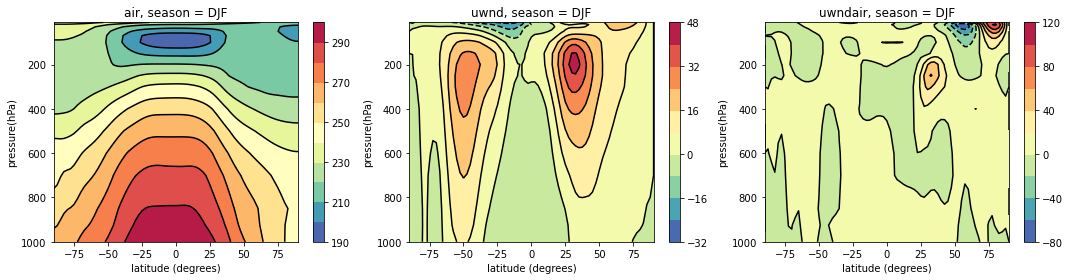

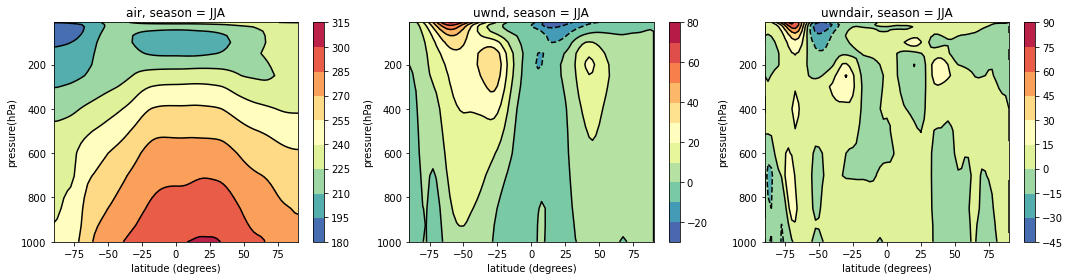

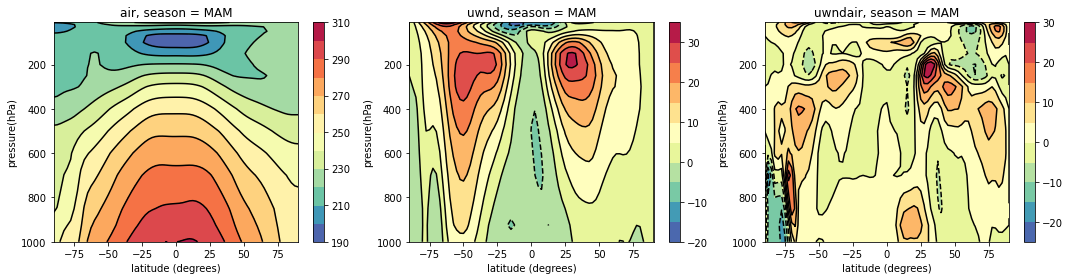

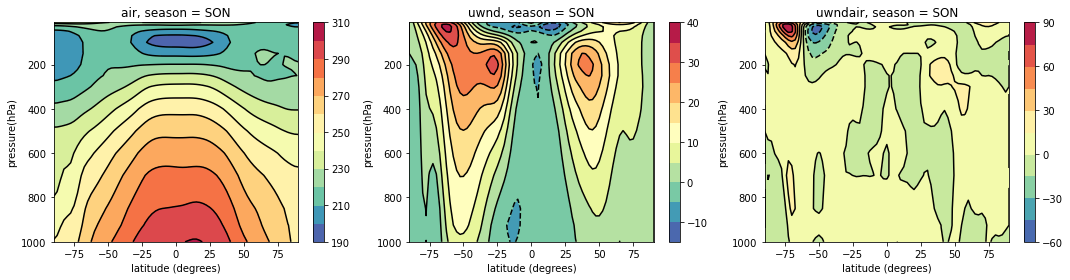

In [95]:
# zonal and time mean variable plots
from matplotlib import pyplot as plt
num_variables = len(result.data_vars)
for i in range(result.dims['season']):
    plt.figure(i,figsize=(20,4))
    #create 1x4 grid of subplots
    for j,variable in enumerate(result.data_vars):
        ax = plt.subplot(1,4,j+1)
        plt.contourf(result['lat'],result['level'],result[variable].isel(season=i),cmap = "Spectral_r", levels=10)
        plt.colorbar()
        plt.contour(result['lat'],result['level'],result[variable].isel(season=i),colors = 'k', levels=10)    
        plt.ylim([1000,10])
        plt.xlabel('latitude (degrees)')
        plt.ylabel('pressure(hPa)')
        plt.title('{0}, season = {1}'.format(variable, result['season'][i].values))
        plt.tight_layout()